In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm 
import plotly.offline as py
from scipy import stats
import plotly.graph_objs as go
import plotly.tools as tls
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [3]:
dataset_train = pd.read_csv(r'C:\Users\Ashish\Desktop\Data Science A-Z\Jantahack8\train.csv')
dataset_test = pd.read_csv(r'C:\Users\Ashish\Desktop\Data Science A-Z\Jantahack8\test.csv')
sample = pd.read_csv(r'C:\Users\Ashish\Desktop\Data Science A-Z\Jantahack8\sample_submission.csv')

In [4]:
dataset_train.shape

(164309, 14)

In [5]:
dataset_train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [6]:
dataset_train.nunique()

Loan_ID                    164309
Loan_Amount_Requested        1290
Length_Employed                11
Home_Owner                      5
Annual_Income               12305
Income_Verified                 3
Purpose_Of_Loan                14
Debt_To_Income               3953
Inquiries_Last_6Mo              9
Months_Since_Deliquency       122
Number_Open_Accounts           58
Total_Accounts                100
Gender                          2
Interest_Rate                   3
dtype: int64

In [7]:
dataset_train.isnull().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [8]:
dataset_train.Length_Employed.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

In [274]:
train = dataset_train.copy()
test = dataset_test.copy()

In [275]:
train.Length_Employed.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

In [276]:
train['Length_Employed'] = train['Length_Employed'].fillna('999')
test['Length_Employed'] = test['Length_Employed'].fillna('999')

In [277]:
train['Length_Employed'] = train['Length_Employed'].map({'999':999,'< 1 year':0,'1 year':1,'2 years':2,'3 years':3,'4 years':4,
                                                         '5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':10}).astype(int)
test['Length_Employed'] = test['Length_Employed'].map({'999':999,'< 1 year':0,'1 year':1,'2 years':2,'3 years':3,'4 years':4,
                                                         '5 years':5,'6 years':6,'7 years':7,'8 years':8,'9 years':9,'10+ years':10}).astype(int)

In [278]:
train['Months_Since_Deliquency'] = train['Months_Since_Deliquency'].fillna(999)
test['Months_Since_Deliquency'] = test['Months_Since_Deliquency'].fillna(999)

In [279]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
Loan_ID                    164309 non-null int64
Loan_Amount_Requested      164309 non-null object
Length_Employed            164309 non-null int32
Home_Owner                 138960 non-null object
Annual_Income              139207 non-null float64
Income_Verified            164309 non-null object
Purpose_Of_Loan            164309 non-null object
Debt_To_Income             164309 non-null float64
Inquiries_Last_6Mo         164309 non-null int64
Months_Since_Deliquency    164309 non-null float64
Number_Open_Accounts       164309 non-null int64
Total_Accounts             164309 non-null int64
Gender                     164309 non-null object
Interest_Rate              164309 non-null int64
dtypes: float64(3), int32(1), int64(5), object(5)
memory usage: 16.9+ MB


In [280]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",0,Rent,68000.0,not verified,car,18.37,0,999.0,9,14,Female,1
1,10000002,"30,000",4,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,999.0,12,16,Male,3
3,10000004,"16,000",0,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,999.0,16,22,Male,3
4,10000005,"17,000",8,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,999.0,19,30,Female,1


In [281]:
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].apply(lambda x: x.replace(",",""))

In [282]:
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].apply(lambda x: x.replace(",",""))

In [283]:
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].astype(float)
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].astype(float)

In [304]:
y_train = train['Interest_Rate']
X_train = train.copy()
X_test = test.copy()
X_train = X_train.drop(['Interest_Rate','Loan_ID'],axis=1)
X_test = X_test.drop(['Loan_ID'],axis=1)

In [305]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

In [286]:
categorical_features = ['Length_Employed','Home_Owner','Income_Verified','Purpose_Of_Loan','Gender','Inquiries_Last_6Mo']

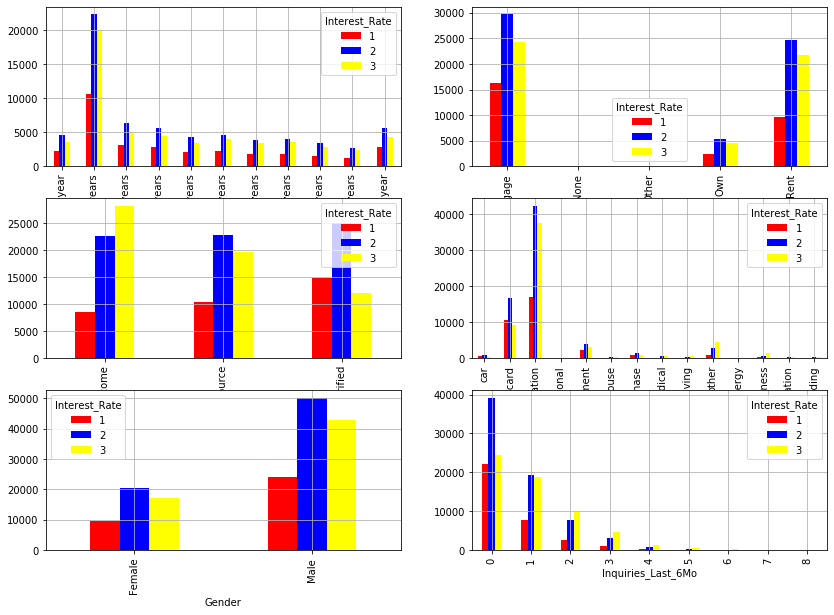

In [171]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(14,10))
AX = [ax1, ax2, ax3, ax4, ax5,ax6]

for i,j in zip(categorical_features,AX):
    temp = pd.crosstab(dataset_train[i],dataset_train['Interest_Rate'])
    temp.plot(kind='bar',stacked=False,color=['red','blue','yellow'],grid=True,ax=j)

In [170]:
for i in categorical_features:
    print(pd.crosstab(train[i],train['Interest_Rate']))


Interest_Rate        1      2      3
Length_Employed                     
-1                1409   3172   2790
 0                2865   5613   4327
 1                2265   4600   3557
 2                3103   6424   5093
 3                2843   5619   4512
 4                2059   4280   3445
 5                2248   4546   4020
 6                1829   3868   3397
 7                1770   3985   3553
 8                1597   3468   2852
 9                1222   2676   2387
 10              10596  22329  19990
Interest_Rate      1      2      3
Home_Owner                        
Mortgage       16365  29689  24291
None               5      1      4
Other             10     25     14
Own             2488   5416   4621
Rent            9719  24637  21675
Interest_Rate                 1      2      3
Income_Verified                              
VERIFIED - income          8568  22670  28183
VERIFIED - income source  10372  22913  19730
not verified              14866  24997  12010
Interes

In [302]:
#X_train['Inquiries_Last_6Mo'] = np.where(X_train['Inquiries_Last_6Mo']>5,6,X_train['Inquiries_Last_6Mo'])
#X_test['Inquiries_Last_6Mo'] = np.where(X_test['Inquiries_Last_6Mo']>5,6,X_test['Inquiries_Last_6Mo'])

In [210]:
X_test['Inquiries_Last_6Mo'].value_counts()

0    56821
1    30720
2    13709
3     5966
4     1501
5      591
6      233
Name: Inquiries_Last_6Mo, dtype: int64

In [56]:
X_train['Income_Verified'].value_counts()

0    59421
1    53015
2    51873
Name: Income_Verified, dtype: int64

In [287]:
#impute caontinuous by mean, cat by mode
for col in X_train.columns:
    if col not in categorical_features:
        X_train[col] = X_train[col].fillna(X_train[col].mean())
        X_test[col] = X_test[col].fillna(X_test[col].mean())
    else:
        X_train[col] = X_train[col].fillna(X_train[col].mode())
        X_test[col] = X_test[col].fillna(X_test[col].mode())
        


In [257]:
categorical_features

['Length_Employed',
 'Home_Owner',
 'Income_Verified',
 'Purpose_Of_Loan',
 'Gender',
 'Inquiries_Last_6Mo']

In [258]:
print(X_train.shape)

(164309, 12)


In [307]:
df = X_train.append(X_test, ignore_index=True)
print(df.shape)

(273850, 12)


In [308]:
#get dummies

temp = pd.get_dummies(df['Length_Employed']).add_prefix('employed_for')
df = df.join(temp)
print(df.shape)

temp = pd.get_dummies(df['Home_Owner']).add_prefix('home_owner_')
df = df.join(temp)
print(df.shape)

temp = pd.get_dummies(df['Income_Verified']).add_prefix('incom_verified')
df = df.join(temp)
print(df.shape)

#temp = pd.get_dummies(df['Inquiries_Last_6Mo']).add_prefix('Last_6m_enq_')
#df = df.join(temp)
#print(df.shape)

#temp = pd.get_dummies(df['Purpose_Of_Loan']).add_prefix('Loan_purpose_')
#df = df.join(temp)
#print(df.shape)

(273850, 24)
(273850, 30)
(273850, 33)


In [309]:
df.columns

Index(['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'employed_for0', 'employed_for1',
       'employed_for2', 'employed_for3', 'employed_for4', 'employed_for5',
       'employed_for6', 'employed_for7', 'employed_for8', 'employed_for9',
       'employed_for10', 'employed_for999', 'home_owner_0', 'home_owner_1',
       'home_owner_2', 'home_owner_3', 'home_owner_4', 'home_owner_5',
       'incom_verified0', 'incom_verified1', 'incom_verified2'],
      dtype='object')

In [293]:
X_train = df.iloc[:164309,:]
X_test = df.iloc[164309:,:]

In [294]:
print(test.shape)
print(X_test.shape)

(109541, 13)
(109541, 33)


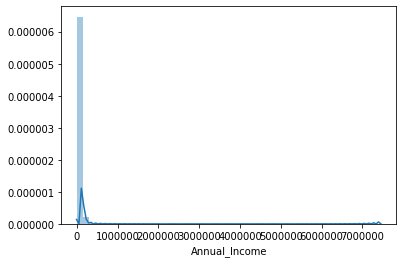

In [263]:
sns.distplot(X_test['Annual_Income'] )

In [219]:
print(np.count_nonzero(X_train['Annual_Income'] > 100000))
print(np.count_nonzero(X_test['Annual_Income'] > 100000))

23212
15430


In [220]:
X_train['Annual_Income'].describe()

count    1.643090e+05
mean     7.333116e+04
std      5.557439e+04
min      4.000000e+03
25%      4.860000e+04
50%      7.000000e+04
75%      8.200000e+04
max      7.500000e+06
Name: Annual_Income, dtype: float64

In [221]:
print(np.count_nonzero(X_train['Annual_Income'] >82000))
print(np.count_nonzero(X_test['Annual_Income'] > 82000))

40743
27192


In [195]:
#X_train['rich_lad'] = (X_train['Annual_Income'] > 82000).astype(int)
#X_test['rich_lad'] = (X_test['Annual_Income'] > 82000).astype(int)

In [114]:
#X_train['Annual_Income'] = np.where(X_train['Annual_Income']>500000,600000,X_train['Annual_Income'])
#X_test['Annual_Income'] = np.where(X_test['Annual_Income']>500000,600000,X_test['Annual_Income'])

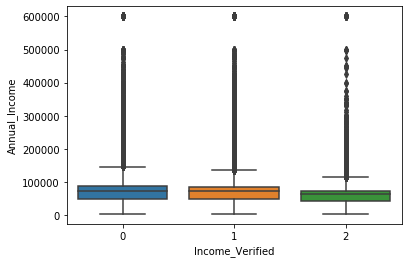

In [117]:
sns.boxplot(x='Income_Verified',y='Annual_Income',data=X_train)

In [295]:
#Cap the income to 200000
X_train['Annual_Income'] = np.where(X_train['Annual_Income']>200000,200000,X_train['Annual_Income'])
X_test['Annual_Income'] = np.where(X_test['Annual_Income']>200000,200000,X_test['Annual_Income'])

In [310]:
#Find incative acounts
X_train['inactive_acc'] = X_train['Total_Accounts'] - X_train['Number_Open_Accounts']
X_test['inactive_acc'] = X_test['Total_Accounts'] - X_test['Number_Open_Accounts']

In [297]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_train, y_train, test_size = .10, random_state = 0, stratify = y_train)


In [298]:
import lightgbm as lgb
print ('Training lightgbm')

# money
params = {
          "objective" : "multiclass",
          "num_class" : 4,
      #    "metric": "auc",
          "num_leaves" : 128,
          "max_depth": -1,
          'boosting': 'gbdt',
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
         "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 20,        # subsample_freq
         # "bagging_seed" : 2018,
          "verbosity" : -1 }

lgb_train = lgb.Dataset(X_train_pre, y_train_pre)
lgb_eval = lgb.Dataset(X_test_pre, y_test_pre, reference=lgb_train)

Training lightgbm


In [299]:
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=17500,
                valid_sets=lgb_eval,
                early_stopping_rounds=150,verbose_eval=100)

Starting training...
Training until validation scores don't improve for 150 rounds.
[100]	valid_0's multi_logloss: 0.975392
[200]	valid_0's multi_logloss: 0.946815
[300]	valid_0's multi_logloss: 0.933932
[400]	valid_0's multi_logloss: 0.927082
[500]	valid_0's multi_logloss: 0.92281
[600]	valid_0's multi_logloss: 0.919781
[700]	valid_0's multi_logloss: 0.918049
[800]	valid_0's multi_logloss: 0.916864
[900]	valid_0's multi_logloss: 0.915835
[1000]	valid_0's multi_logloss: 0.91513
[1100]	valid_0's multi_logloss: 0.914722
[1200]	valid_0's multi_logloss: 0.914211
[1300]	valid_0's multi_logloss: 0.913947
[1400]	valid_0's multi_logloss: 0.913927
[1500]	valid_0's multi_logloss: 0.913691
[1600]	valid_0's multi_logloss: 0.913529
[1700]	valid_0's multi_logloss: 0.913617
Early stopping, best iteration is:
[1642]	valid_0's multi_logloss: 0.91348


In [300]:
gbm.feature_importance()

array([96002, 28154, 14104, 85423, 15020, 28259, 97811, 20162, 50247,
       43381, 50210,  6390,   370,  1892,  2203,  2286,  2067,  1931,
        1920,  1987,  1646,  1436,  3331,   348,  1348,     0,    18,
        2631,  6801,   459,  1385,  4755,   783, 50842])

In [272]:
X_train.columns

Index(['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'employed_for-1', 'employed_for0',
       'employed_for1', 'employed_for2', 'employed_for3', 'employed_for4',
       'employed_for5', 'employed_for6', 'employed_for7', 'employed_for8',
       'employed_for9', 'employed_for10', 'home_owner_0', 'home_owner_1',
       'home_owner_2', 'home_owner_3', 'home_owner_4', 'home_owner_5',
       'incom_verified0', 'incom_verified1', 'incom_verified2', 'istype_1',
       'inactive_acc'],
      dtype='object')

In [301]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))
sample['Interest_Rate'] = predictions
sample.to_csv(r"C:\Users\Ashish\Desktop\Data Science A-Z\Jantahack8\sub_lgb.csv",index=False)

Starting predicting...
